In [1]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math

### Load model

In [2]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [3]:
t_span = (0, 15)
N = 512
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [4]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [5]:
alpha_list = [0.2]
ic_list = [[1.59, 0.95]]
epsilon_list = [0.1]
p_list = [6]

In [6]:
ode = equations.lv_normalized(alpha_list[0])

sol = numerical.solve_ode_equation(ode, t_span, t_eval, ic_list[0])
x, y = sol

## Lindstedt-Poincare method

In [7]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution_LKV(epsilon_list, p_list, ic_list, alpha_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

perturbation order 0
perturbation order 1
running cal_w_n first time
1 1 1 1
perturbation order 2
running cal_w_n first time
2 2 2 2
perturbation order 3
running cal_w_n first time
3 3 3 3
perturbation order 4
running cal_w_n first time
4 4 4 4
perturbation order 5
running cal_w_n first time
5 5 5 5
perturbation order 6
running cal_w_n first time
6 6 6 6


In [8]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(LPM.calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-12))

w_final_list

series has diverged for order p = 6


[[np.float64(0.4472135954999579),
  np.float64(0.3534073758404374),
  np.float64(0.3684329150161049),
  np.float64(0.3702439601225306),
  np.float64(0.36911930912840146),
  np.float64(0.36901314850347455)]]

In [ ]:
#_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
#w_teor

NameError: name 'w_list_transfer' is not defined

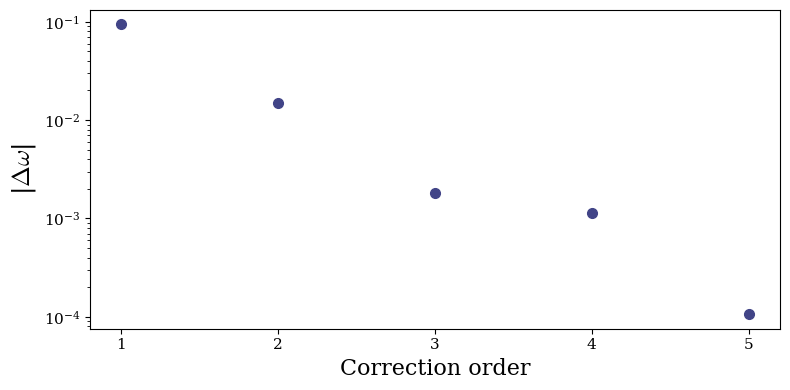

In [10]:
LPM.relative_error(w_final_list[0])
#LPM.w_absolute_error(w_final_list[0], w_teor)

In [11]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

/tmp/ipykernel_23490/3033459835.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


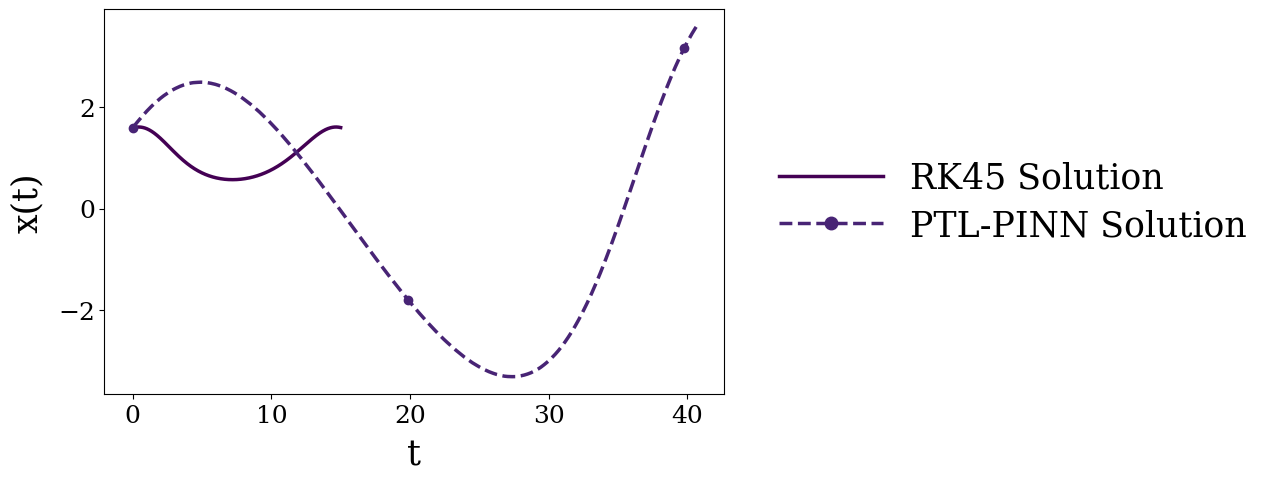

In [17]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_solution(t_eval, t_eval_lpm, y_num, y_nn, i = 0):
    title_fs  = 25
    label_fs  = 25
    tick_fs   = 18
    legend_fs = 25
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / 2)
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / 2)


    ax.plot(t_eval, y_num,
            label="RK45 Solution",
            color=rk_color, linewidth=2.5)

    ax.plot(t_eval_lpm, y_nn,
            label="PTL-PINN Solution",
            color=pinn_color, linewidth=2.5,
            linestyle="--", marker="o", markevery=250)

    ax.set_xlabel("t", fontsize=label_fs, labelpad=8)
    ax.set_ylabel("x(t)", fontsize=label_fs, labelpad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)

    # Set y-limits with padding
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y): anchor the legend outside the right border
    fontsize=legend_fs,
    frameon=False,
    handlelength=3.0,
    markerscale=1.5,
    labelspacing=0.4,
    borderaxespad=0.8)
    plt.show()

plot_solution(t_eval, t_eval_lpm, x, NN_TL_solution_LPM[:, 0], i = 0)